In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import os
from tqdm.notebook import tqdm
!pip install pydub
from pydub import AudioSegment
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mosaic/data')

In [ ]:
df

,Unnamed: 0,start,end,crackles,wheezes,patient_id,recording_idx,chest_location,acquisition_mode,filename
0,0,1.010,3.581,0,0,172,1b5,Al,mc,172_1b5_Al_mc_AKGC417L
1,1,3.581,6.836,0,1,172,1b5,Al,mc,172_1b5_Al_mc_AKGC417L
2,2,6.836,9.624,1,0,172,1b5,Al,mc,172_1b5_Al_mc_AKGC417L
3,3,9.624,12.262,0,0,172,1b5,Al,mc,172_1b5_Al_mc_AKGC417L
4,4,12.262,15.801,0,0,172,1b5,Al,mc,172_1b5_Al_mc_AKGC417L
...,...,...,...,...,...,...,...,...,...,...
6105,1,2.513,5.634,1,0,151,2p3,Ar,mc,151_2p3_Ar_mc_AKGC417L
6106,2,5.634,9.124,0,1,151,2p3,Ar,mc,151_2p3_Ar_mc_AKGC417L
6107,3,9.124,12.529,1,0,151,2p3,Ar,mc,151_2p3_Ar_mc_AKGC417L
6108,4,12.529,15.668,1,0,151,2p3,Ar,mc,151_2p3_Ar_mc_AKGC417L


In [ ]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
audio_file = df['filename'][0]

In [ ]:
audio_path = "/content/drive/MyDrive/mosaic/audio_files/" + audio_file + ".wav"

In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio(audio_path, rate=7000))

In [ ]:
y, sr = librosa.load(audio_path)
print(y,sr)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

[ 0.          0.          0.         ... -0.09633426 -0.09459218
 -0.1039257 ] 22050


In [ ]:
tempo,beat_times

(array([151.99908088]),
 array([ 0.13931973,  0.48761905,  0.81269841,  1.20743764,  1.60217687,
         1.9969161 ,  2.39165533,  2.80961451,  3.18113379,  3.55265306,
         3.92417234,  4.27247166,  4.64399093,  5.0155102 ,  5.41024943,
         5.80498866,  6.22294785,  6.61768707,  7.03564626,  7.43038549,
         7.80190476,  8.17342404,  8.52172336,  8.89324263,  9.31120181,
         9.729161  , 10.12390023, 10.51863946, 10.93659864, 11.35455782,
        11.77251701, 12.16725624, 12.56199546, 12.95673469, 13.32825397,
        13.7229932 , 14.11773243, 14.4892517 , 14.88399093, 15.27873016,
        15.67346939, 16.04498866, 16.41650794, 16.78802721]))

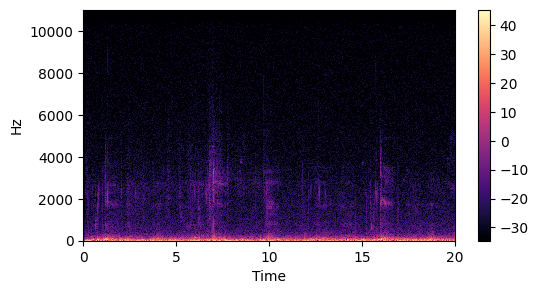

In [ ]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

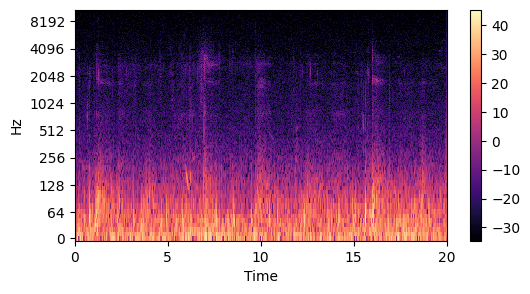

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

(20, 862)
22050


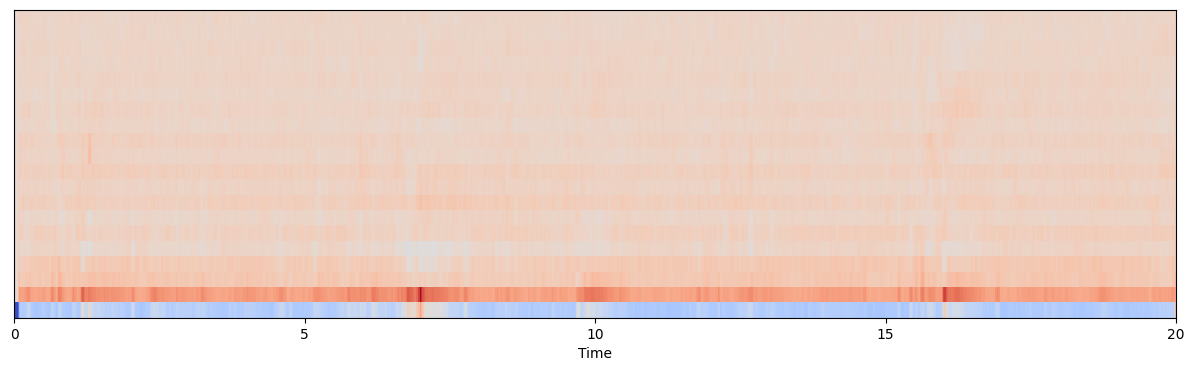

In [ ]:
fs=10
mfccs = librosa.feature.mfcc(y=y, sr=fs)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 4))
print(sr)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
def GetPureAudio(raw, start, end, sr=22050):
  max_ind = len(raw)
  start_ind = min(int(start * sr), max_ind)
  end_ind = min(int(end * sr), max_ind)
  return raw[start_ind: end_ind]

<Axes: ylabel='None'>

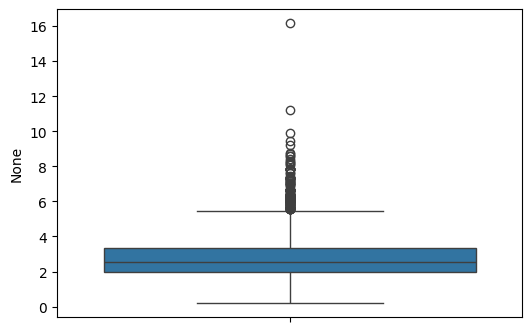

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=(df.end - df.start))

In [ ]:
# Creating directory for storing process audio files
# os.makedirs('/content/drive/MyDrive/mosaic/processed_audio_files')

In [ ]:
df.loc[1,:]

start                                3.581
end                                  6.836
crackles                                 0
wheezes                                  1
patient_id                             172
recording_idx                          1b5
chest_location                          Al
acquisition_mode                        mc
filename            172_1b5_Al_mc_AKGC417L
Name: 1, dtype: object

In [ ]:
i = 0
c = 0
files = []
for index, row in tqdm(df.iterrows()):
    max_length = 6
    start_time = row['start']
    end_time = row['end']
    filename = row['filename']

    # if segment duration exceeds the maximum then truncate it
    if end_time - start_time > max_length:
        end = start_time + max_length

    audio_file_location = "/content/drive/MyDrive/mosaic/audio_files/" + filename + '.wav'

    # Checking if this row is part of the same patient's audio recording
    if index > 0:
        if df.iloc[index-1]['filename'] == filename:
            i += 1
        else:
            i = 0
    filename = filename + '_' + str(i)
    files.append(filename)
    save_path = '/content/drive/MyDrive/mosaic/processed_audio_files/' + filename + '.wav'
    c += 1

    # Loading original audio file and getting pure audio
    audio, samplerate = librosa.load(audio_file_location)
    pure_sample = GetPureAudio(audio ,start_time ,end_time,samplerate)

    # Calculating required length
    required_length = max(6 * samplerate, len(pure_sample))
    padded_data = librosa.util.pad_center(pure_sample, size=required_length)

# split
    # Save the processed audio segment to the specified path
    sf.write(file=save_path, data=padded_data, samplerate=samplerate)

print('Total Files Processed: ',c)

In [ ]:
df['filename'] = files

NameError: name 'files' is not defined

In [ ]:
def determine_sound(row):
    if row['crackles'] and row['wheezes']:
        return 'both'
    elif row['crackles']:
        return 'crackle'
    elif row['wheezes']:
        return 'wheeze'
    else:
        return 'none'

df['sound'] = df.apply(determine_sound, axis=1)


In [ ]:
df["sound"].value_counts()

In [ ]:
df.drop(["crackles","wheezes"],axis = 1,inplace = True)

In [ ]:
df

In [ ]:
df.to_csv('/content/drive/MyDrive/mosaic/final_df')

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/mosaic/final_df')

In [ ]:
y = df["sound"]
X = df.drop(["sound"],axis = 1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y, random_state = 42, test_size = 0.2)

In [ ]:
y_train.value_counts()/y_train.shape[0]

sound
none       0.518412
crackle    0.280278
wheeze     0.125614
both       0.075696
Name: count, dtype: float64

In [ ]:
y_test.value_counts()/y_test.shape[0]

sound
none       0.518822
crackle    0.279869
wheeze     0.126023
both       0.075286
Name: count, dtype: float64

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
def get_features_from_audio(path):
    soundArr,sample_rate= librosa.load(path)
    mfcc=librosa.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=librosa.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=librosa.feature.melspectrogram(y=soundArr,sr=sample_rate)
    tone = librosa.feature.tonnetz(y=soundArr,sr=sample_rate)
    specCen = librosa.feature.spectral_centroid(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec,tone, specCen

In [ ]:
root = '/content/drive/MyDrive/mosaic/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(X_test.iterrows()):
    path=root + row['filename']+'.wav'
    a,b,c,d,e=get_features_from_audio(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

In [ ]:
shapes = [np.shape(sub_list) for sub_list in mfcc]

unique_shapes = set(shapes)

print(unique_shapes)

In [ ]:
shapes1 = [np.shape(sub_list) for sub_list in cstft]

unique_shapes1 = set(shapes1)

print(unique_shapes1)

In [ ]:
shapes2 = [np.shape(sub_list) for sub_list in mSpec]

unique_shapes2 = set(shapes2)

print(unique_shapes2)

In [ ]:
# Determine the minimum shape among all subarrays for mfcc
min_shape = min(sub_array.shape for sub_list in mfcc for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mfcc_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mfcc
]

# Determine the minimum shape among all subarrays for cstft
min_shape = min(sub_array.shape for sub_list in cstft for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
cstft_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in cstft
]

# Determine the minimum shape among all subarrays for mSpec
min_shape = min(sub_array.shape for sub_list in mSpec for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mSpec_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mSpec
]

In [ ]:
# Converting the padded list of lists of NumPy arrays into a NumPy array
mfcc_test = np.array(mfcc_padded)
cstft_test = np.array(cstft_padded)
mSpec_test = np.array(mSpec_padded)

print(f"mfcc: {mfcc_test.shape}")
print(f"cstft: {cstft_test.shape}")
print(f"mSpec: {mSpec_test.shape}")

In [ ]:
root = '/content/drive/MyDrive/mosaic/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(X_train.iterrows()):
    path=root + row['filename'] + '.wav'
    a,b,c,d,e=get_features_from_audio(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

In [ ]:
shapes = [np.shape(sub_list) for sub_list in mfcc]
unique_shapes = set(shapes)
print(unique_shapes)

In [ ]:
shapes = [np.shape(sub_list) for sub_list in cstft]
unique_shapes = set(shapes)
print(unique_shapes)

In [ ]:
shapes = [np.shape(sub_list) for sub_list in mSpec]
unique_shapes = set(shapes)
print(unique_shapes)

In [ ]:
# Determine the minimum shape among all subarrays for mfcc
min_shape = min(sub_array.shape for sub_list in mfcc for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mfcc_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mfcc
]

# Determine the minimum shape among all subarrays for cstft
min_shape = min(sub_array.shape for sub_list in cstft for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
cstft_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in cstft
]

# Determine the minimum shape among all subarrays for mSpec
min_shape = min(sub_array.shape for sub_list in mSpec for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mSpec_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mSpec
]

In [ ]:

# Converting the padded list of lists of NumPy arrays into a NumPy array
mfcc_train = np.array(mfcc_padded_train)
cstft_train = np.array(cstft_padded_train)
mSpec_train = np.array(mSpec_padded_train)

print(f"mfcc: {mfcc_train.shape}")
print(f"cstft: {cstft_train.shape}")
print(f"mSpec: {mSpec_train.shape}")

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    verbose=1,
),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=0.00001,
)
]

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

In [ ]:
cstft_input=keras.layers.Input(shape=(12,259,1),name="cstftInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(cstft_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
cstft_output=keras.layers.GlobalMaxPooling2D()(x)

cstft_model=keras.Model(cstft_input, cstft_output, name="cstftModel")

In [ ]:
cstft_model.summary()

In [ ]:
mspec_input=keras.layers.Input(shape=(128,259,1),name="mspecInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mspec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mspec_output=keras.layers.GlobalMaxPooling2D()(x)

mspec_model=keras.Model(mspec_input, mspec_output, name="mspecModel")

In [ ]:
mspec_model.summary()

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_cstft=keras.layers.Input(shape=(12,259,1),name="cstft")
cstft=cstft_model(input_cstft)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mspec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,cstft,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_cstft,input_mSpec], output, name="Net")

In [ ]:
net.summary()

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"cstft":cstft_train,"mspec":mSpec_train},
    y_train,
    validation_data=({"mfcc":mfcc_test,"cstft":cstft_test,"mspec":mSpec_test},y_test),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)

In [ ]:
history.save("/content/drive/MyDrive/mosaic/model1.h5")

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()